<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural - Bert Sentiment Analysis


En el presente desafio se realizará un modelo de clasificación de sentimiento sobre valoraciones almacenadas en un dataset.

> info: El presente notebook se ejecuto completamente en el entorno de colab, por lo que su ejecución en el entorno poetry del repositorio no esta garantizada

## Preparación de entorno

En un primer momento se prepara el entorno, para lo cual se modifica la versión de tensorflow a la versión requerida por el notebook previsto por la cátedra.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.0


In [3]:
!pip install tensorflow==2.15
!pip install transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [4]:
import tensorflow
from transformers import TFBertModel

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Funciones utilizadas

In [5]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

In [6]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512, output_shape=3):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

## Entrenamientos

### Entrenamientos con 3 categorias

A continuación se van a realizar 2 entrenamientos utilizando diferentes tamaños máximos de sentencias. Principalmente utilizaremos 140 y 320. A partir de dichos entrenamientos, se realizaran comparaciones sobre los resultados obtenidos.
Cabe destacar que se tuvo que modificar el tamaño de batch entre 31 y 16 dependiendo de los tamaños utilizados debido a limitaciones de vRAM disponible.

#### Preparación de los datos de entrenamiento

A continuación se descargan los datasets a utilizar y se trabajan los mismos para poder ser utilizados en el desarrollo del modelo

In [7]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  50622      0  0:00:02  0:00:02 --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   688k      0  0:00:10  0:00:10 --:--:-- 1850k


In [8]:
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [9]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

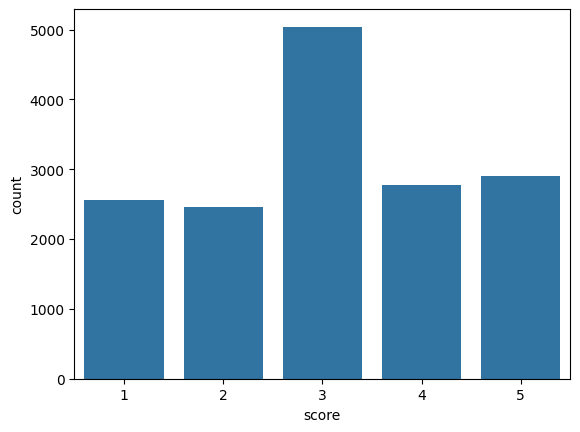

In [10]:
sns.countplot(x=df.score)

Como se puede observar hay un grán desvalance de los datos, por lo cual se propone realizar una simplificación en 3 clases para lograr una mejor distribución de los mismos.

In [11]:
# Balancear los datos
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

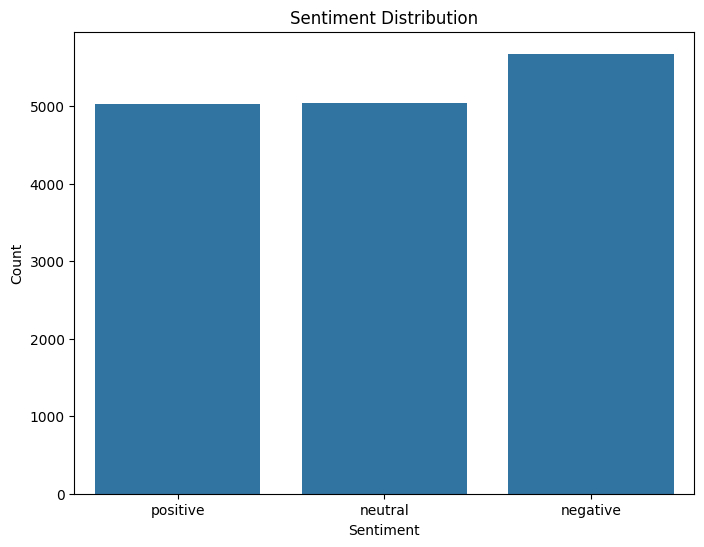

In [12]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(ticks=sentiment_counts.index, labels=class_names) # Set labels
plt.show()

In [13]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


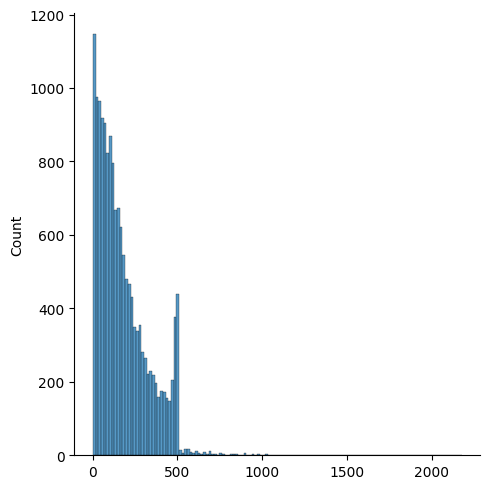

In [14]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

Como se puede observar la mayoría de las sentencias tienen un largo mejor a 500, lo cual es bueno debido a que el modelo bert solo maneja hasta un largod e 512.

In [15]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = tensorflow.keras.utils.to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
output shape: 3


#### Entrenamiento 1: Con max_length igual a 140

In [ ]:
max_length = 140
output_shape = 3

In [ ]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

##### Generador de datos


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [ ]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [ ]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [ ]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [ ]:
y_test = y[idx_test]

##### bert clasificador multiclase

In [ ]:
history_base_1 = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
315/315 [==============================] - 178s 431ms/step - loss: 1.1071 - accuracy: 0.4020 - f1_score: 0.3960 - val_loss: 1.0043 - val_accuracy: 0.5234 - val_f1_score: 0.4421
Epoch 2/10
315/315 [==============================] - 130s 412ms/step - loss: 1.0339 - accuracy: 0.4643 - f1_score: 0.4551 - val_loss: 0.9987 - val_accuracy: 0.4774 - val_f1_score: 0.3992
Epoch 3/10
315/315 [==============================] - 130s 412ms/step - loss: 0.9968 - accuracy: 0.4971 - f1_score: 0.4863 - val_loss: 0.9534 - val_accuracy: 0.5429 - val_f1_score: 0.4486
Epoch 4/10
315/315 [==============================] - 129s 411ms/step - loss: 0.9732 - accuracy: 0.5180 - f1_score: 0.5071 - val_loss: 0.9243 - val_accuracy: 0.5464 - val_f1_score: 0.5247
Epoch 5/10
315/315 [==============================] - 130s 413ms/step - loss: 0.9646 - accuracy: 0.5258 - f1_score: 0.5169 - val_loss: 0.9133 - val_accuracy: 0.5599 - val_f1_score: 0.4811
Epoch 6/10
315/315 [==============================] - 130s 4

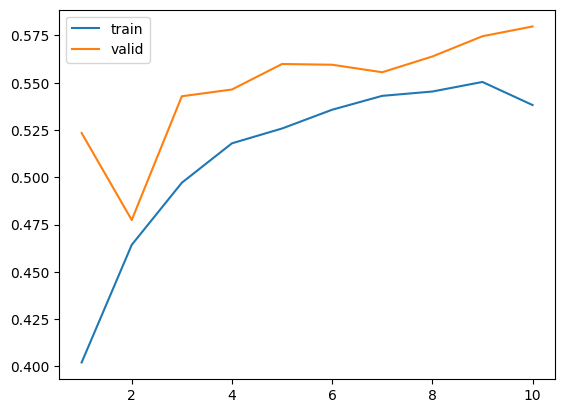

In [ ]:
plot_train_metrics(history_base_1)

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 41s 309ms/step


array([[0.49131027, 0.35292438, 0.1557653 ],
       [0.40807518, 0.29622278, 0.295702  ],
       [0.19762523, 0.39944854, 0.40292627]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 41s 314ms/step - loss: 0.8724 - accuracy: 0.5905 - f1_score: 0.5734


0.5904762148857117

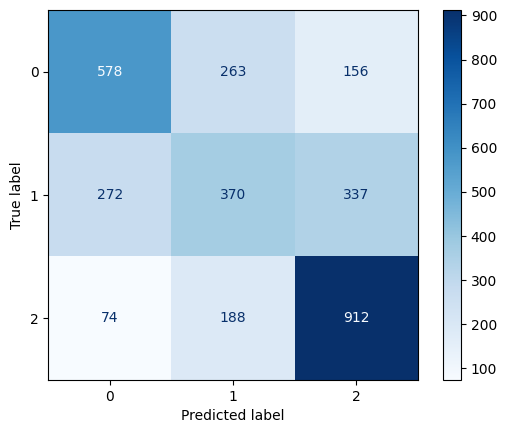

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(3)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

##### BERT Fine tuning

In [ ]:
# Colocar todas las layers como entrenables
for layer in model.layers:
  layer.trainable = True

# Compilar el modelo con el optimizador
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

In [ ]:
history_fine_1 = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
315/315 [==============================] - 373s 997ms/step - loss: 0.7525 - accuracy: 0.6525 - f1_score: 0.6462 - val_loss: 0.6725 - val_accuracy: 0.6984 - val_f1_score: 0.6829
Epoch 2/10
315/315 [==============================] - 302s 960ms/step - loss: 0.6111 - accuracy: 0.7308 - f1_score: 0.7270 - val_loss: 0.6317 - val_accuracy: 0.7290 - val_f1_score: 0.7192
Epoch 3/10
315/315 [==============================] - 302s 959ms/step - loss: 0.4837 - accuracy: 0.8011 - f1_score: 0.7988 - val_loss: 0.6149 - val_accuracy: 0.7726 - val_f1_score: 0.7702
Epoch 4/10
315/315 [==============================] - 303s 961ms/step - loss: 0.3419 - accuracy: 0.8620 - f1_score: 0.8605 - val_loss: 0.6724 - val_accuracy: 0.7909 - val_f1_score: 0.7859
Epoch 5/10
315/315 [==============================] - 303s 960ms/step - loss: 0.2225 - accuracy: 0.9149 - f1_score: 0.9143 - val_loss: 0.7342 - val_accuracy: 0.8091 - val_f1_score: 0.8081
Epoch 6/10
315/315 [==============================] - 302s 9

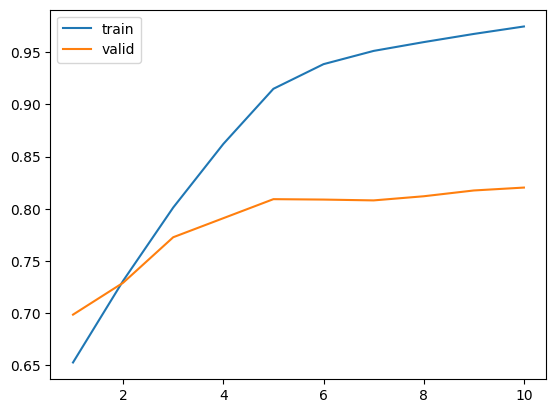

In [ ]:
plot_train_metrics(history_fine_1)

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 40s 312ms/step


array([[2.4106327e-01, 2.8867775e-01, 4.7025901e-01],
       [9.9969208e-01, 3.0783814e-04, 7.3422086e-08],
       [2.7630965e-03, 9.8810971e-01, 9.1272201e-03]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 40s 316ms/step - loss: 1.0749 - accuracy: 0.8159 - f1_score: 0.8140


0.8158730268478394

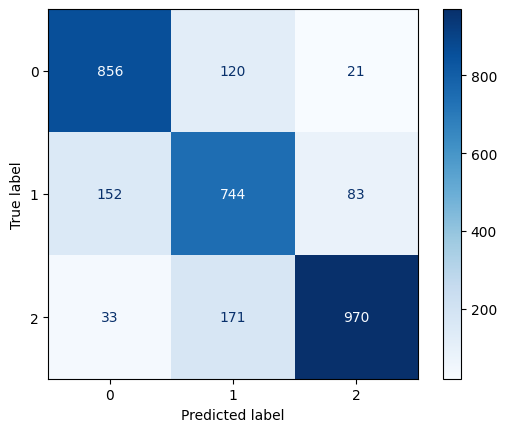

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(3)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

##### guardar modelo

In [ ]:
model.save_weights('bert_model_train_1.h5')

#### Entrenamiento 2: Con max_length igual a 320

In [ ]:
max_length = 320
output_shape = 3

In [ ]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 320)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 320)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 320, 7                                       

##### Generador de datos


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [ ]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [ ]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [ ]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [ ]:
y_test = y[idx_test]

##### bert clasificador multiclase

In [ ]:
history_base_2 = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
315/315 [==============================] - 232s 614ms/step - loss: 1.0990 - accuracy: 0.4150 - f1_score: 0.4100 - val_loss: 1.0183 - val_accuracy: 0.4508 - val_f1_score: 0.3836
Epoch 2/10
315/315 [==============================] - 184s 584ms/step - loss: 1.0363 - accuracy: 0.4672 - f1_score: 0.4585 - val_loss: 0.9896 - val_accuracy: 0.4909 - val_f1_score: 0.4104
Epoch 3/10
315/315 [==============================] - 184s 584ms/step - loss: 0.9943 - accuracy: 0.5002 - f1_score: 0.4896 - val_loss: 0.9328 - val_accuracy: 0.5512 - val_f1_score: 0.5083
Epoch 4/10
315/315 [==============================] - 184s 584ms/step - loss: 0.9763 - accuracy: 0.5188 - f1_score: 0.5088 - val_loss: 0.9183 - val_accuracy: 0.5492 - val_f1_score: 0.4948
Epoch 5/10
315/315 [==============================] - 184s 584ms/step - loss: 0.9606 - accuracy: 0.5263 - f1_score: 0.5160 - val_loss: 0.9048 - val_accuracy: 0.5607 - val_f1_score: 0.5043
Epoch 6/10
315/315 [==============================] - 184s 5

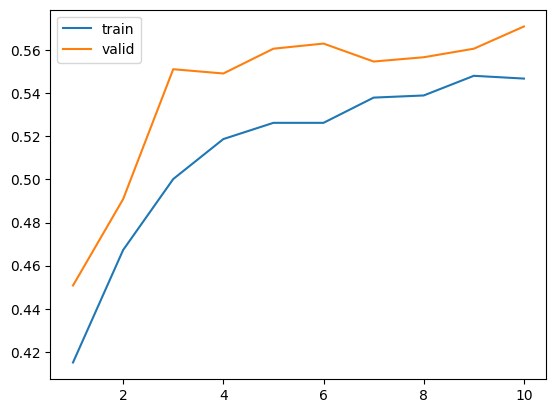

In [ ]:
plot_train_metrics(history_base_2)

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 50s 414ms/step


array([[0.5623003 , 0.27079445, 0.16690516],
       [0.4548887 , 0.24869755, 0.2964138 ],
       [0.2101858 , 0.32138494, 0.46842933]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 51s 416ms/step - loss: 0.8820 - accuracy: 0.5768 - f1_score: 0.5184


0.5768253803253174

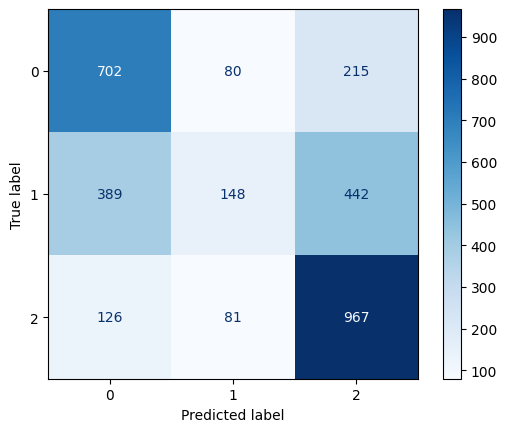

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(3)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

##### BERT Fine tuning

In [ ]:
# Colocar todas las layers como entrenables
for layer in model.layers:
  layer.trainable = True

# Compilar el modelo con el optimizador
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 320)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 320)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 320, 7                                       

In [ ]:
history_fine_2 = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
315/315 [==============================] - 481s 1s/step - loss: 0.7543 - accuracy: 0.6528 - f1_score: 0.6460 - val_loss: 0.6687 - val_accuracy: 0.6968 - val_f1_score: 0.6877
Epoch 2/10
315/315 [==============================] - 414s 1s/step - loss: 0.6123 - accuracy: 0.7250 - f1_score: 0.7213 - val_loss: 0.6353 - val_accuracy: 0.7222 - val_f1_score: 0.7143
Epoch 3/10
315/315 [==============================] - 414s 1s/step - loss: 0.4915 - accuracy: 0.7963 - f1_score: 0.7940 - val_loss: 0.6410 - val_accuracy: 0.7472 - val_f1_score: 0.7374
Epoch 4/10
315/315 [==============================] - 414s 1s/step - loss: 0.3458 - accuracy: 0.8631 - f1_score: 0.8619 - val_loss: 0.7063 - val_accuracy: 0.7865 - val_f1_score: 0.7823
Epoch 5/10
315/315 [==============================] - 414s 1s/step - loss: 0.2249 - accuracy: 0.9101 - f1_score: 0.9093 - val_loss: 0.7438 - val_accuracy: 0.8048 - val_f1_score: 0.8047
Epoch 6/10
315/315 [==============================] - 414s 1s/step - loss: 

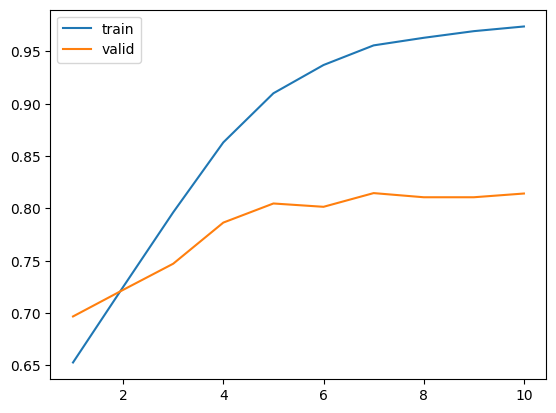

In [ ]:
plot_train_metrics(history_fine_2)

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 50s 414ms/step


array([[3.59478444e-01, 6.39473319e-01, 1.04822614e-03],
       [8.78090799e-01, 1.21839814e-01, 6.94236878e-05],
       [2.91717413e-04, 9.94240999e-01, 5.46730869e-03]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [ ]:
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 50s 417ms/step - loss: 1.0545 - accuracy: 0.8184 - f1_score: 0.8178


0.818412721157074

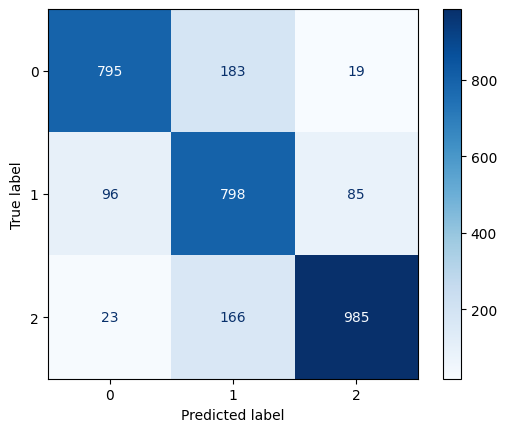

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(3)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

##### guardar modelo

In [ ]:
model.save_weights('bert_model_train_2.h5')

### Entrenamiento con 4 categorias

A continuación se va a realizar el entrenamiento con las 5 categorias del dataset original.

#### Preparación de los datos de entrenamiento

In [47]:
print(df['score'].unique())

[1 2 3 4 5]


Se elimina el 0 como una categoría para que el método to_categorical no utilice 6 categorias cuando en realidad son solo 5. Lo que puede generar problemas en el entrenamiento del modelo

In [50]:
# Balancear los datos
df['score_with0'] = df.score.apply(lambda x: x-1)

In [51]:
y = df['score_with0'].values
print("y shape:", y.shape)
y = tensorflow.keras.utils.to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


#### Entrenamiento 3: Con max_length igual a 140

In [52]:
max_length = 140
output_shape = 5

In [53]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
bert_model.summary()

Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

##### Generador de datos


In [57]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [58]:
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [59]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [60]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length,output_shape=output_shape)
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length,output_shape=output_shape)
validation_data = validation_data.batch(32)

In [61]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [62]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [63]:
y_test = y[idx_test]

##### bert clasificador multiclase

In [64]:
history_base_3 = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
315/315 [==============================] - 191s 452ms/step - loss: 1.5974 - accuracy: 0.2908 - f1_score: 0.2187 - val_loss: 1.4843 - val_accuracy: 0.3929 - val_f1_score: 0.3179
Epoch 2/5
315/315 [==============================] - 131s 417ms/step - loss: 1.5162 - accuracy: 0.3353 - f1_score: 0.2581 - val_loss: 1.4372 - val_accuracy: 0.4040 - val_f1_score: 0.3228
Epoch 3/5
315/315 [==============================] - 131s 417ms/step - loss: 1.4772 - accuracy: 0.3645 - f1_score: 0.2991 - val_loss: 1.3978 - val_accuracy: 0.4357 - val_f1_score: 0.3411
Epoch 4/5
315/315 [==============================] - 132s 417ms/step - loss: 1.4451 - accuracy: 0.3772 - f1_score: 0.3048 - val_loss: 1.3892 - val_accuracy: 0.4044 - val_f1_score: 0.2941
Epoch 5/5
315/315 [==============================] - 147s 468ms/step - loss: 1.4225 - accuracy: 0.3852 - f1_score: 0.3135 - val_loss: 1.3857 - val_accuracy: 0.3762 - val_f1_score: 0.3504


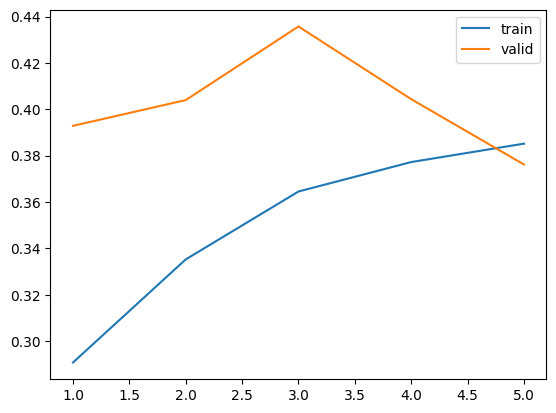

In [65]:
plot_train_metrics(history_base_3)

In [66]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 41s 318ms/step


array([[0.28760672, 0.27338004, 0.2590837 , 0.10233984, 0.07758967],
       [0.25463957, 0.3062643 , 0.18360119, 0.12981343, 0.12568147],
       [0.10684963, 0.2428661 , 0.25374147, 0.23749927, 0.15904357]],
      dtype=float32)

In [67]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [68]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 41s 315ms/step - loss: 1.3815 - accuracy: 0.3860 - f1_score: 0.3673


0.38603174686431885

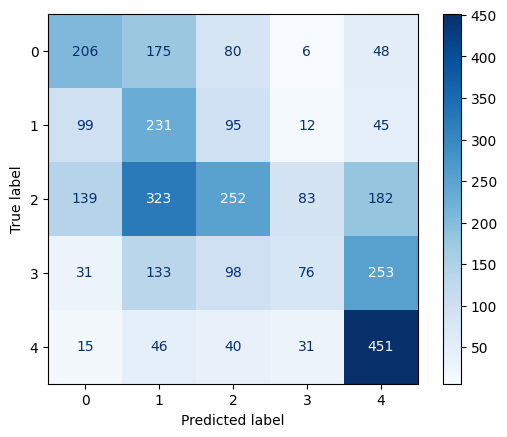

In [70]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

##### BERT Fine tuning

In [71]:
# Colocar todas las layers como entrenables
for layer in model.layers:
  layer.trainable = True

# Compilar el modelo con el optimizador
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

In [72]:
history_fine_3 = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
315/315 [==============================] - 378s 1s/step - loss: 1.1429 - accuracy: 0.5049 - f1_score: 0.4569 - val_loss: 1.0705 - val_accuracy: 0.5417 - val_f1_score: 0.4877
Epoch 2/10
315/315 [==============================] - 306s 973ms/step - loss: 0.9773 - accuracy: 0.5824 - f1_score: 0.5514 - val_loss: 0.9983 - val_accuracy: 0.5984 - val_f1_score: 0.5652
Epoch 3/10
315/315 [==============================] - 306s 971ms/step - loss: 0.8212 - accuracy: 0.6596 - f1_score: 0.6365 - val_loss: 0.9913 - val_accuracy: 0.6258 - val_f1_score: 0.5974
Epoch 4/10
315/315 [==============================] - 306s 971ms/step - loss: 0.6553 - accuracy: 0.7396 - f1_score: 0.7287 - val_loss: 1.0577 - val_accuracy: 0.6409 - val_f1_score: 0.6218
Epoch 5/10
315/315 [==============================] - 306s 971ms/step - loss: 0.4955 - accuracy: 0.8092 - f1_score: 0.8025 - val_loss: 1.0940 - val_accuracy: 0.6909 - val_f1_score: 0.6783
Epoch 6/10
315/315 [==============================] - 306s 972m

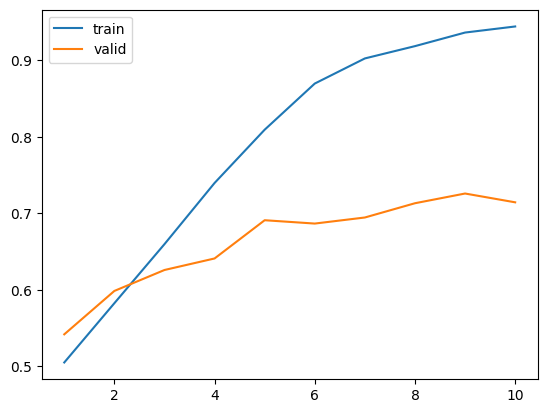

In [73]:
plot_train_metrics(history_fine_3)

In [74]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 40s 318ms/step


array([[2.44206600e-02, 5.46588302e-01, 2.80772865e-01, 1.47967026e-01,
        2.51172722e-04],
       [8.85216236e-01, 1.14366584e-01, 4.11915273e-04, 3.60687238e-07,
        4.93152720e-06],
       [1.09904366e-04, 6.16567070e-03, 8.97622705e-01, 9.58930328e-02,
        2.08703495e-04]], dtype=float32)

In [75]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [76]:
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 40s 316ms/step - loss: 1.5167 - accuracy: 0.7108 - f1_score: 0.6998


0.710793673992157

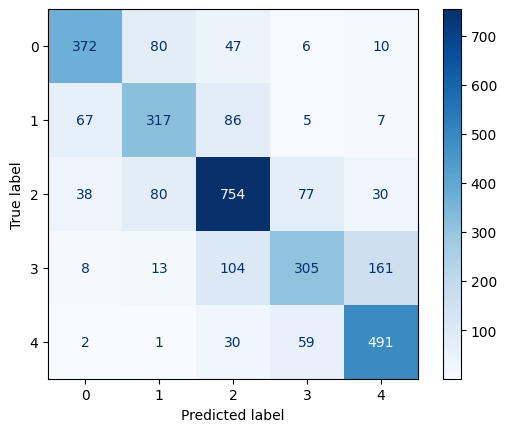

In [77]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(5)))
cmd.plot(cmap=plt.cm.Blues)
plt.show()

##### guardar modelo

In [78]:
model.save_weights('bert_model_train_3.h5')

## Conclusiones

### Comparación entre entrenamientos con 3 categorías

* Exactitud: Al comparar los entrenamientos realizados con tres categorías, parece que los modelos lograron una exactitud relativamente buena, aunque hubo señales de sobreajuste (overfitting).

* Comportamiento de los modelos: Todos los modelos entrenados mostraron una tendencia a sobreajustar los datos, lo que significa que aprendieron demasiado bien los patrones del conjunto de entrenamiento, pero les costaba generalizar en los datos de prueba.

* Tamaño de las oraciones: Al modificar el tamaño de las sentencias, no se notó una mejora significativa en el rendimiento del modelo en las tres categorías. Esto podría deberse a que el tamaño de la secuencia no estaba limitando al modelo, o el contexto proporcionado era ya suficiente para el modelo de BERT.

### Resultados obtenidos con 5 categorías

Cuando se aumentó el número de categorías de tres a cinco:

* El rendimiento del modelo se redujo debido a la mayor dificultad que implica clasificar en más categorías.

* El sobreajuste continuó siendo un problema, y el modelo no pudo generalizar bien, lo que podría estar relacionado con una mayor variabilidad en las clases que el modelo no pudo captar correctamente.

### Overfitting: causas y soluciones

El sobreajuste observado se puede atribuir a varios factores:

* Pocos datos: Si el conjunto de datos no es lo suficientemente grande, el modelo puede memorizar los ejemplos en lugar de aprender patrones generalizables.

* Modelo complejo: BERT es un modelo muy potente con una gran cantidad de parámetros, lo que lo hace susceptible al sobreajuste en conjuntos de datos pequeños.